# Workbook

In [4]:
# import necessary packages

import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from IPython import display
import tensorflow as tf
import pandas as pd
import librosa 

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [5]:
audio_path = 'dataset/AUDIO_NEW/breathing/'

In [196]:
# Define paths
POS = os.path.join(audio_path, 'COVID_Positive')
NEG = os.path.join(audio_path, 'COVID_Negative')

In [200]:
from pathlib import Path

# Specify the directory path
pos_directory = Path(POS)
neg_directory = Path(NEG)

# List all files in the directory using iterdir()
pos_files = [file.name for file in pos_directory.iterdir() if file.is_file()]
neg_files = [file.name for file in neg_directory.iterdir() if file.is_file()]

In [218]:
# List to store spectrograms and labels
spectrograms = []
labels = []

for file_path in pos_directory.iterdir():
    y, sr = librosa.load(file_path.resolve(), sr=16000)
    y = y[:80000]

    zero_padding = np.zeros(80000 - len(y), dtype=np.float32)
    y = np.concatenate([y, zero_padding],axis=0)
    
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=512, hop_length=128, n_mels=128)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Normalize the spectrogram
    log_mel_spectrogram = (log_mel_spectrogram - np.mean(log_mel_spectrogram)) / np.std(log_mel_spectrogram)

    log_mel_spectrogram = np.expand_dims(log_mel_spectrogram, axis=-1)  # Add channel dimension
    
    # Append to list
    spectrograms.append(log_mel_spectrogram)
    
    labels.append(1)  # Assuming binary classification

for file_path in neg_directory.iterdir():
    y, sr = librosa.load(file_path.resolve(), sr=16000)
    y = y[:80000]

    zero_padding = np.zeros(80000 - len(y), dtype=np.float32)
    y = np.concatenate([y, zero_padding],axis=0)
    
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=512, hop_length=128, n_mels=128)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    if np.std(log_mel_spectrogram) == 0:
        print(file_path.resolve())
    # Normalize the spectrogram
    epsilon = 1e-6  # Small value to avoid division by zero
    log_mel_spectrogram = (log_mel_spectrogram - np.mean(log_mel_spectrogram)) / (np.std(log_mel_spectrogram) + epsilon)
    
    log_mel_spectrogram = np.expand_dims(log_mel_spectrogram, axis=-1)  # Add channel dimension
    #print(log_mel_spectrogram.shape)
    # Append to list
    spectrograms.append(log_mel_spectrogram)
    
    labels.append(0)  

(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 626, 1)
(128, 

In [251]:
X_train, X_test, y_train, y_test = train_test_split(spectrograms, labels, test_size=0.2, stratify=labels)

In [256]:
# Flatten each spectrogram into a single vector
# Resulting shape will be (num_samples, height * width * channels)
X_train_numpy = np.array(X_train)
X_train_flattened = X_train_numpy.reshape(X_train_numpy.shape[0], -1)

print(f"Original shape: {X_train_numpy.shape}")
print(f"Flattened shape: {X_train_flattened.shape}")

Original shape: (772, 128, 626, 1)
Flattened shape: (772, 80128)


In [257]:
from imblearn.combine import SMOTEENN
from collections import Counter

smote_enn = SMOTEENN(random_state=seed)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_flattened, y_train)

# Print resampled class distribution
print(f"Resampled class distribution: {Counter(y_resampled)}")

Resampled class distribution: Counter({1: 621, 0: 181})


In [258]:
# Reshape back to original format after resampling
X_resampled = X_resampled.reshape(X_resampled.shape[0], 128, 626, 1)

print(f"Reshaped back to original format: {X_resampled.shape}")

Reshaped back to original format: (802, 128, 626, 1)


In [269]:
y_resampled = np.array(y_resampled)

In [259]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, GlobalAveragePooling2D

In [260]:
model = Sequential()
model.add(Input(shape=(625,128,1)))

# First Conv2D layer followed by MaxPooling
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2))) # Reduces spatial dimensions by half

# Second Conv2D layer followed by MaxPooling
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2))) # Further reduces spatial dimensions

# Third Conv2D layer followed by MaxPooling
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2))) # Further reduces spatial dimensions

# Fourth Conv2D layer followed by MaxPooling (new)
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2))) # Further reduces spatial dimensions

# Flatten and Dense layers
#model.add(Flatten())
model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [261]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [262]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_31 (Conv2D)              │ (None, 623, 126, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 311, 63, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 309, 61, 16)    │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 154, 30, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 152, 28, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 76, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 74, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 37, 6, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,065 (133.07 KB)

 Trainable params: 34,065 (133.07 KB)

 Non-trainable params: 0 (0.00 B)

### Fit Model, View Loss and KPI Plots

In [268]:
X_resampled

array([[[[-1.02334142e+00],
         [-1.02334142e+00],
         [-1.02334142e+00],
         ...,
         [-8.69689524e-01],
         [-1.02334142e+00],
         [-1.02334142e+00]],

        [[-1.02334142e+00],
         [-1.02334142e+00],
         [-1.02334142e+00],
         ...,
         [-8.73609364e-01],
         [-1.02334142e+00],
         [-1.02334142e+00]],

        [[-1.02334142e+00],
         [-1.02334142e+00],
         [-1.02334142e+00],
         ...,
         [-8.74854863e-01],
         [-1.02334142e+00],
         [-1.02334142e+00]],

        ...,

        [[-1.02334142e+00],
         [-1.02334142e+00],
         [-1.02334142e+00],
         ...,
         [-1.02334142e+00],
         [-1.02334142e+00],
         [-1.02334142e+00]],

        [[-1.02334142e+00],
         [-1.02334142e+00],
         [-1.02334142e+00],
         ...,
         [-1.02334142e+00],
         [-1.02334142e+00],
         [-1.02334142e+00]],

        [[-1.02334142e+00],
         [-1.02334142e+00],
         [

In [270]:
hist = model.fit(X_resampled, y_resampled, batch_size = 16, verbose = 2, epochs=20, validation_split = 0.1)

Epoch 1/20
46/46 - 6s - 134ms/step - loss: 0.7467 - precision_7: 0.7398 - recall_7: 0.6056 - val_loss: 0.2740 - val_precision_7: 1.0000 - val_recall_7: 1.0000
Epoch 2/20
46/46 - 6s - 138ms/step - loss: 0.5762 - precision_7: 0.7490 - recall_7: 1.0000 - val_loss: 0.2933 - val_precision_7: 1.0000 - val_recall_7: 1.0000
Epoch 3/20
46/46 - 6s - 129ms/step - loss: 0.5634 - precision_7: 0.7490 - recall_7: 1.0000 - val_loss: 0.2672 - val_precision_7: 1.0000 - val_recall_7: 1.0000
Epoch 4/20
46/46 - 7s - 156ms/step - loss: 0.5496 - precision_7: 0.7490 - recall_7: 1.0000 - val_loss: 0.2313 - val_precision_7: 1.0000 - val_recall_7: 1.0000
Epoch 5/20
46/46 - 8s - 185ms/step - loss: 0.5322 - precision_7: 0.7490 - recall_7: 1.0000 - val_loss: 0.2460 - val_precision_7: 1.0000 - val_recall_7: 1.0000
Epoch 6/20
46/46 - 6s - 141ms/step - loss: 0.5130 - precision_7: 0.7490 - recall_7: 1.0000 - val_loss: 0.2300 - val_precision_7: 1.0000 - val_recall_7: 1.0000
Epoch 7/20
46/46 - 6s - 136ms/step - loss: 0.4

In [271]:
X_test = np.array(X_test)
y_test = np.array(y_test)

y_pred = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


In [272]:
y_pred_binary = (y_pred > 0.99).astype(int)

In [273]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_binary)

In [274]:
len(y_test)

193

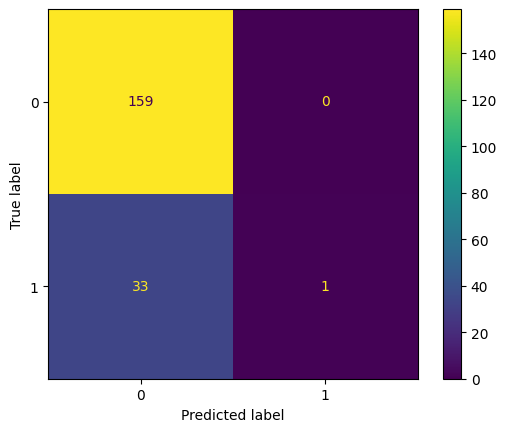

In [275]:
disp = ConfusionMatrixDisplay(cm)

disp.plot()
plt.show()